In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip3 install torch torchvision pandas transformers scikit-learn tensorflow numpy seaborn matplotlib textwrap3 sentencepiece

     |████████████████████████████████| 2.0MB 16.2MB/s 
     |████████████████████████████████| 1.2MB 40.0MB/s 
     |████████████████████████████████| 870kB 36.3MB/s 
     |████████████████████████████████| 3.2MB 45.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=d8ca5b8aec35343e9e88f97ecdf4e1c09d35bf3cd7082f654203fb422efd7b2f
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
import transformers
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torchvision import transforms
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'

def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.,!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

def label_to_target(text):
  if text == "informative":
    return 1
  else:
    return 0

df_train = pd.read_csv("./gdrive/MyDrive/FYP/task_informative_text_img_agreed_lab_train.tsv", sep='\t')
df_train = df_train[['image', 'tweet_text', 'label_text']]
df_train = df_train.sample(frac=1, random_state = 24).reset_index(drop=True)
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_text)
df_train['label_text'] = df_train['label_text'].apply(label_to_target)

df_val = pd.read_csv("./gdrive/MyDrive/FYP/task_informative_text_img_agreed_lab_dev.tsv", sep='\t')
df_val = df_val[['image', 'tweet_text', 'label_text']]
df_val = df_val.sample(frac=1, random_state = 24).reset_index(drop=True)
df_val['tweet_text'] = df_val['tweet_text'].apply(clean_text)
df_val['label_text'] = df_val['label_text'].apply(label_to_target)

df_test = pd.read_csv("./gdrive/MyDrive/FYP/task_informative_text_img_agreed_lab_test.tsv", sep='\t')
df_test = df_test[['image', 'tweet_text', 'label_text']]
df_test = df_test.sample(frac=1, random_state = 24).reset_index(drop=True)
df_test['tweet_text'] = df_test['tweet_text'].apply(clean_text)
df_test['label_text'] = df_test['label_text'].apply(label_to_target)


In [ ]:
data_dir = "./gdrive/MyDrive/FYP/"
class DisasterTweetDataset(Dataset):

  def __init__(self, tweets, targets, paths, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.paths = paths
    self.transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    path = str(self.paths[item])
    img = Image.open(data_dir+self.paths[item]).convert('RGB')
    img = self.transform(img)  

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'tweet_image': img
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = DisasterTweetDataset(
    tweets=df.tweet_text.to_numpy(),
    targets=df.label_text.to_numpy(),
    paths=df.image.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )


class TweetClassifier(nn.Module):

  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.bert = XLNetModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    for param in self.bert.parameters():
      param.requires_grad = False
    
    self.resnet = torchvision.models.densenet161(pretrained=True)
    for param in self.resnet.parameters():
      param.requires_grad = False
    
    self.bn = nn.BatchNorm1d(self.bert.config.hidden_size + 1000)

    self.linear1 = nn.Linear(self.bert.config.hidden_size + 1000, 1000)
    self.relu1    = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.4)

    self.linear2 = nn.Linear(1000, 500)
    self.relu2    = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.2)

    self.linear3 = nn.Linear(500, 250)
    self.relu3    = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.1)

    self.linear4 = nn.Linear(250, 125)
    self.relu4    = nn.ReLU()
    self.dropout4 = nn.Dropout(p=0.02)

    self.linear5 = nn.Linear(125, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input_ids, attention_mask, tweet_img):
    text_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    image_output = self.resnet(tweet_img)
    merged_output = torch.cat((torch.mean(text_output[0], 1), image_output), dim=1)
    bn_output = self.bn(merged_output)

    linear1_output = self.linear1(bn_output)
    relu1_output = self.relu1(linear1_output)
    dropout1_output = self.dropout1(relu1_output)

    linear2_output = self.linear2(dropout1_output)
    relu2_output = self.relu2(linear2_output)
    dropout2_output = self.dropout2(relu2_output)

    linear3_output = self.linear3(dropout2_output)
    relu3_output = self.relu3(linear3_output)
    dropout3_output = self.dropout3(relu3_output)

    linear4_output = self.linear4(dropout3_output)
    relu4_output = self.relu4(linear4_output)
    dropout4_output = self.dropout4(relu4_output)

    linear5_output = self.linear5(dropout4_output)


    probas = self.sigmoid(linear5_output)
    return probas


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    tweet_imgs = d["tweet_image"].to(device)
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].reshape(-1, 1).float()
    targets = targets.to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      tweet_img = tweet_imgs
    )


    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(torch.round(outputs) == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      tweet_imgs = d["tweet_image"].to(device)
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(torch.round(outputs) == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
BATCH_SIZE = 512
MAX_LEN = 150

tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


model = TweetClassifier()
model = model.to(device)

EPOCHS = 50

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.BCELoss().to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


In [ ]:
checkpoint = torch.load("./gdrive/MyDrive/FYP/XlnetDenseNet-checkpoint.t7",map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
best_accuracy = checkpoint['best_accuracy']

print(start_epoch)
print(best_accuracy)

45
tensor(0.8608, dtype=torch.float64)


In [ ]:
history = defaultdict(list)
start_epoch = 0
best_accuracy = -1

# checkpoint = torch.load("./gdrive/MyDrive/FYP/BertResNet-checkpoint.t7")
# model.load_state_dict(checkpoint['state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# start_epoch = checkpoint['epoch']
# best_accuracy = checkpoint['best_accuracy']
# print(start_epoch)
# print(best_accuracy)


for epoch in range(EPOCHS):

  print(f'Epoch {start_epoch + epoch + 1}/{start_epoch + EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    state = {
            'best_accuracy': val_acc,
            'epoch': start_epoch+epoch+1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
    }
    savepath= "./gdrive/MyDrive/FYP/XlnetDenseNet-checkpoint.t7"
    torch.save(state,savepath)
    best_accuracy = val_acc

Epoch 1/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.6283384498796964 accuracy 0.6608686595146339
Val   loss 0.5200000926852226 accuracy 0.6713286713286714

Epoch 2/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4963518914423491 accuracy 0.74148526195188
Val   loss 0.4666155055165291 accuracy 0.8073744437380801

Epoch 3/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.4083490857952519 accuracy 0.8359545880637433
Val   loss 0.43005045503377914 accuracy 0.817546090273363

Epoch 4/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3447404864587282 accuracy 0.852619518800125
Val   loss 0.43914075195789337 accuracy 0.8378893833439288

Epoch 5/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.31689108045477615 accuracy 0.8660556192063327
Val   loss 0.4355715438723564 accuracy 0.8366179275270185

Epoch 6/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.3047790903794138 accuracy 0.8727215915008852
Val   loss 0.4282035008072853 accuracy 0.8372536554354736

Epoch 7/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2945401723447599 accuracy 0.8738673054890115
Val   loss 0.42117369174957275 accuracy 0.8385251112523839

Epoch 8/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2829990786941428 accuracy 0.8831371732111238
Val   loss 0.41651417315006256 accuracy 0.8429752066115702

Epoch 9/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.275643884351379 accuracy 0.8858452244557858
Val   loss 0.41285619884729385 accuracy 0.8486967577876668

Epoch 10/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.27286938381822484 accuracy 0.8842828871992501
Val   loss 0.4111899882555008 accuracy 0.8474253019707565

Epoch 11/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.263441590886367 accuracy 0.8926153525674408
Val   loss 0.4082261249423027 accuracy 0.8506039415130324

Epoch 12/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.26245065974561793 accuracy 0.8916779502135194
Val   loss 0.4103905186057091 accuracy 0.8506039415130324

Epoch 13/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2558985423100622 accuracy 0.8950109363607958
Val   loss 0.4067070484161377 accuracy 0.8512396694214877

Epoch 14/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.248439537851434 accuracy 0.8967815852515363
Val   loss 0.414140522480011 accuracy 0.8506039415130324

Epoch 15/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24936995851366142 accuracy 0.8966774294344338
Val   loss 0.40889425575733185 accuracy 0.8556897647806739

Epoch 16/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24710906022473386 accuracy 0.8995937923133007
Val   loss 0.3985000401735306 accuracy 0.8556897647806739

Epoch 17/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24009959556554494 accuracy 0.9012602853869388
Val   loss 0.4092273786664009 accuracy 0.8486967577876668

Epoch 18/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.24072562550243579 accuracy 0.9013644412040412
Val   loss 0.4130200147628784 accuracy 0.8499682136045773

Epoch 19/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23755711238635213 accuracy 0.9018852202895531
Val   loss 0.4214118868112564 accuracy 0.8499682136045773

Epoch 20/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2303505484995089 accuracy 0.9049057389855223
Val   loss 0.41411617398262024 accuracy 0.8506039415130324

Epoch 21/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.23299890050762578 accuracy 0.907509634413082
Val   loss 0.41566654294729233 accuracy 0.8512396694214877

Epoch 22/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2271720516054254 accuracy 0.9094885949380273
Val   loss 0.4252639338374138 accuracy 0.8486967577876668

Epoch 23/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22425221142015958 accuracy 0.9068846995104677
Val   loss 0.4149976074695587 accuracy 0.8512396694214877

Epoch 24/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22408988601283023 accuracy 0.9063639204249557
Val   loss 0.41362815350294113 accuracy 0.8537825810553084

Epoch 25/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.218344332356202 accuracy 0.911571711280075
Val   loss 0.41454017162323 accuracy 0.8531468531468531

Epoch 26/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.21476431975239202 accuracy 0.9118841787313822
Val   loss 0.40407029539346695 accuracy 0.856325492689129

Epoch 27/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.22022278685318797 accuracy 0.908863660035413
Val   loss 0.4066637009382248 accuracy 0.8537825810553084

Epoch 28/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2157282476362429 accuracy 0.912404957816894
Val   loss 0.4069979786872864 accuracy 0.8518753973299428

Epoch 29/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2107383585289905 accuracy 0.9158420997812727
Val   loss 0.4053039848804474 accuracy 0.8556897647806739

Epoch 30/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20773591807014063 accuracy 0.9166753463180919
Val   loss 0.4074869751930237 accuracy 0.8544183089637635

Epoch 31/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.21317485602278458 accuracy 0.9139672950734298
Val   loss 0.4071211740374565 accuracy 0.8569612205975843

Epoch 32/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20335348499448677 accuracy 0.9175085928549109
Val   loss 0.4065582901239395 accuracy 0.8569612205975843

Epoch 33/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20160982169603048 accuracy 0.9193833975627539
Val   loss 0.4031887352466583 accuracy 0.8588684043229498

Epoch 34/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20608167664000862 accuracy 0.9179252161233205
Val   loss 0.4041738212108612 accuracy 0.859504132231405

Epoch 35/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20181600984774137 accuracy 0.9184459952088324
Val   loss 0.40512924641370773 accuracy 0.859504132231405

Epoch 36/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20387342885920876 accuracy 0.916467034683887
Val   loss 0.4119744151830673 accuracy 0.8550540368722187

Epoch 37/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.2055130577401111 accuracy 0.9160504114154775
Val   loss 0.4098929315805435 accuracy 0.856325492689129

Epoch 38/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20251081491771497 accuracy 0.9191750859285491
Val   loss 0.41219837963581085 accuracy 0.8569612205975843

Epoch 39/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19787097290942543 accuracy 0.922403916258723
Val   loss 0.4104027897119522 accuracy 0.8575969485060394

Epoch 40/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19656885689810702 accuracy 0.9215706697219039
Val   loss 0.4085155725479126 accuracy 0.8582326764144946

Epoch 41/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20237982429956136 accuracy 0.916987813769399
Val   loss 0.41053202748298645 accuracy 0.8582326764144946

Epoch 42/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1982601339879789 accuracy 0.9199041766482657
Val   loss 0.40829722583293915 accuracy 0.859504132231405

Epoch 43/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19419307693054802 accuracy 0.9230288511613374
Val   loss 0.409753680229187 accuracy 0.859504132231405

Epoch 44/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19887304384457438 accuracy 0.9200083324653682
Val   loss 0.40952862799167633 accuracy 0.8588684043229498

Epoch 45/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19291809122813375 accuracy 0.9221956046245182
Val   loss 0.407737173140049 accuracy 0.8607755880483153

Epoch 46/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19319367957742592 accuracy 0.9217789813561087
Val   loss 0.4060199409723282 accuracy 0.8607755880483153

Epoch 47/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.20025098010113365 accuracy 0.9193833975627539
Val   loss 0.40563011914491653 accuracy 0.8601398601398601

Epoch 48/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19544740256510282 accuracy 0.9211540464534944
Val   loss 0.4070287421345711 accuracy 0.8601398601398601

Epoch 49/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.1926906650003634 accuracy 0.9228205395271326
Val   loss 0.4072047770023346 accuracy 0.8601398601398601

Epoch 50/50
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Train loss 0.19613003966055417 accuracy 0.9213623580876992
Val   loss 0.406931571662426 accuracy 0.8601398601398601



In [ ]:
state = {
        'epoch': start_epoch + EPOCHS,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
}
savepath= "./gdrive/MyDrive/FYP/XlnetDenseNet-checkpoint-{}.t7".format(start_epoch + EPOCHS)
torch.save(state,savepath)

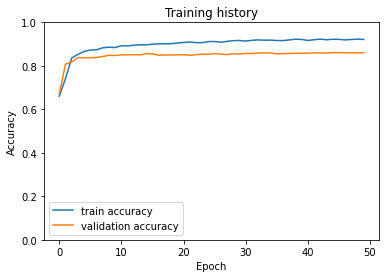

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      tweet_imgs = d["tweet_image"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].reshape(-1, 1).float()
      targets = targets.to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        tweet_img = tweet_imgs
      )
      preds = torch.round(outputs)


      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values

y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=['Not Informative', 'Informative']))

NameError: ignored